# Predicting Pancreatic Cancer Using Urinary Biomarkers and an Ensemble of Machine Learning Algorithms

### 1. Importing libraries and modules

The libraries and modules used throughout the project are:

In [3]:
# Import libraries and modules
import matplotlib.pyplot as plt    # Data visualization
import pandas as pd                # Data manipulation and analysis  
import seaborn as sns              # High-level interface for data visualization

from sklearn.compose import ColumnTransformer                          # Transformers to columns of dataframes/arrays
from sklearn.ensemble import RandomForestClassifier, VotingClassifier  # Ensemble learning methods for classification
from sklearn.metrics import accuracy_score, roc_auc_score              # Classification scores
from sklearn.model_selection import GridSearchCV                       # Technique for hyperparameter tuning
from sklearn.model_selection import RepeatedStratifiedKFold            # Cross-validation estimator for ML models
from sklearn.model_selection import train_test_split                   # Function to split data in training and test sets
from sklearn.neighbors import KNeighborsClassifier                     # Classifier implementing the k-nearest neighbors vote
from sklearn.pipeline import Pipeline                                  # Assemble several steps to be cross-validated together
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler # Data preprocessing techniques
from sklearn.svm import SVC                                            # Supervised ML method for classification

%matplotlib inline                                                     # Enable inline plotting

UsageError: unrecognized arguments: # Enable inline plotting


### 2. Data loading and exploratory analysis

#### 2.1. Load data

The data as downloaded from Kaggle in CSV (Comma Separated Value) format is loaded in pandas data frame. <br>
The shape of the data frame is (590, 14) corresponding to the 590 samples and 14 columns/features.

In [67]:
# Load data
df = pd.read_csv('./pancreatic_biomarkers.csv')   # Load a CSV file in pandas DataFrame 
df.shape                                          # Shape of the dataframe >>> (590, 14) 

(590, 14)

The 14 columns are:

In [68]:
df.columns                                        # Columns of the dataframe

Index(['sample_id', 'patient_cohort', 'sample_origin', 'age', 'sex',
       'diagnosis', 'stage', 'benign_sample_diagnosis', 'plasma_CA19_9',
       'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
      dtype='object')

There are three unique diagnosis in the 'diagnosis' column which correspond to the following target labels:<br>
 - 3 : PDAC
 - 2 : benign condition
 - 1 : healthy control

In [69]:
# Explore target diagnosis
df['diagnosis'].unique() 

array([1, 2, 3], dtype=int64)

For clarity, these labels have been mapped to the corresponding integer values.

In [70]:
# Map integer to corresponding diagnosis
target_diagnosis = {
    3 :'PDAC',
    2 :'Benign condition',
    1 :'Healthy control'
}
# Replace integers in pandas column with corresponding diagnosis
df['diagnosis'] = df['diagnosis'].map(lambda x: target_diagnosis[x])

# Explore target diagnosis after replacing integers with diagnosis
df['diagnosis'].unique() 

array(['Healthy control', 'Benign condition', 'PDAC'], dtype=object)

#### 2.2. Visualize sample count

To explore the distribution of classes in the data set the number of samples per class has been plotted using a countplot:

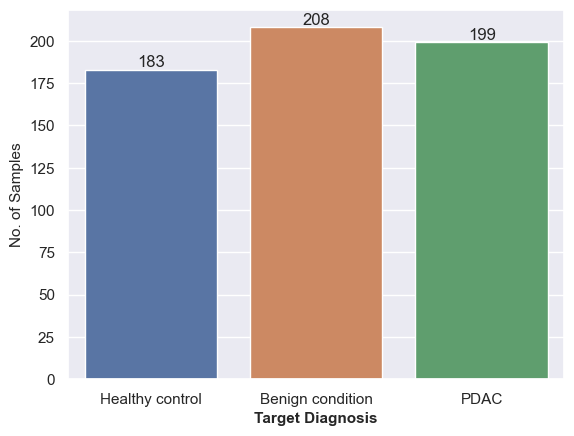

In [46]:
# Visualize sample count
sns.set()                                          # Reset plot style 
ax = sns.countplot(x=df['diagnosis'])              # Plot sample count per diagnosis
ax.bar_label(ax.containers[0])                     # Display bar count 
ax.set_xlabel('Target Diagnosis',                  # Set label for the X-axis
              fontsize=11, fontweight='bold')  
ax.set_ylabel('No. of Samples', fontsize=11)       # Set label for the Y-axis
plt.show()                                         # Show plot

The results presented in the figure above, indicate that each output class (or target class) is to a great extent represented by almost equal number of input samples, namely, the data set can be considered as balanced.

#### 2.3. Feature engineering

For diagnosis, I have used the same five predictors (features) that constitute the PancRISK score: age, creatinine, and a biomarker panel with three proteins (LYVE1, REG1B, and TFF1). 

Before selection, I have investigated each column of the data frame for missing values, and as it turns out the relevant features contain none. Therefore, in the next steps only the columns from the predictors list have been selected for further study. 

In [47]:
# Feature selection: five PancRISK predictors 
predictors = ['age', 'creatinine', 'LYVE1', 'REG1B', 'TFF1']

# Exploring missing values in each column
df.isna().sum()

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

I have considered the performance of the predictors in differentiating healthy individuals with no known pancreatic
conditions or malignancies or history of renal diseases at the time of collection from PDAC patients (healthy control vs. PDAC). As a result, I have split the data in X features and y target classes by dropping the rows which correspond to a ’Benign condition’ and selecting only the columns from the predictors list.

In [48]:
# Get features and target diagnosis
X = df[predictors][df.diagnosis != 'Benign condition'] 
y = df['diagnosis'][df.diagnosis != 'Benign condition'] 

#### 2.4. Visualize distribution of data

Before applying any machine learning (ML) algorithm, it is important to explore the input features visually to identify the distribution of the data, because many models (with the exception of tree-based models) are not scale invariant and/or might perform poorly if the numeric features do not (more or less) follow a standard Gaussian (normal) distribution. For this purpose,
I took a look at the histograms with density for each feature:

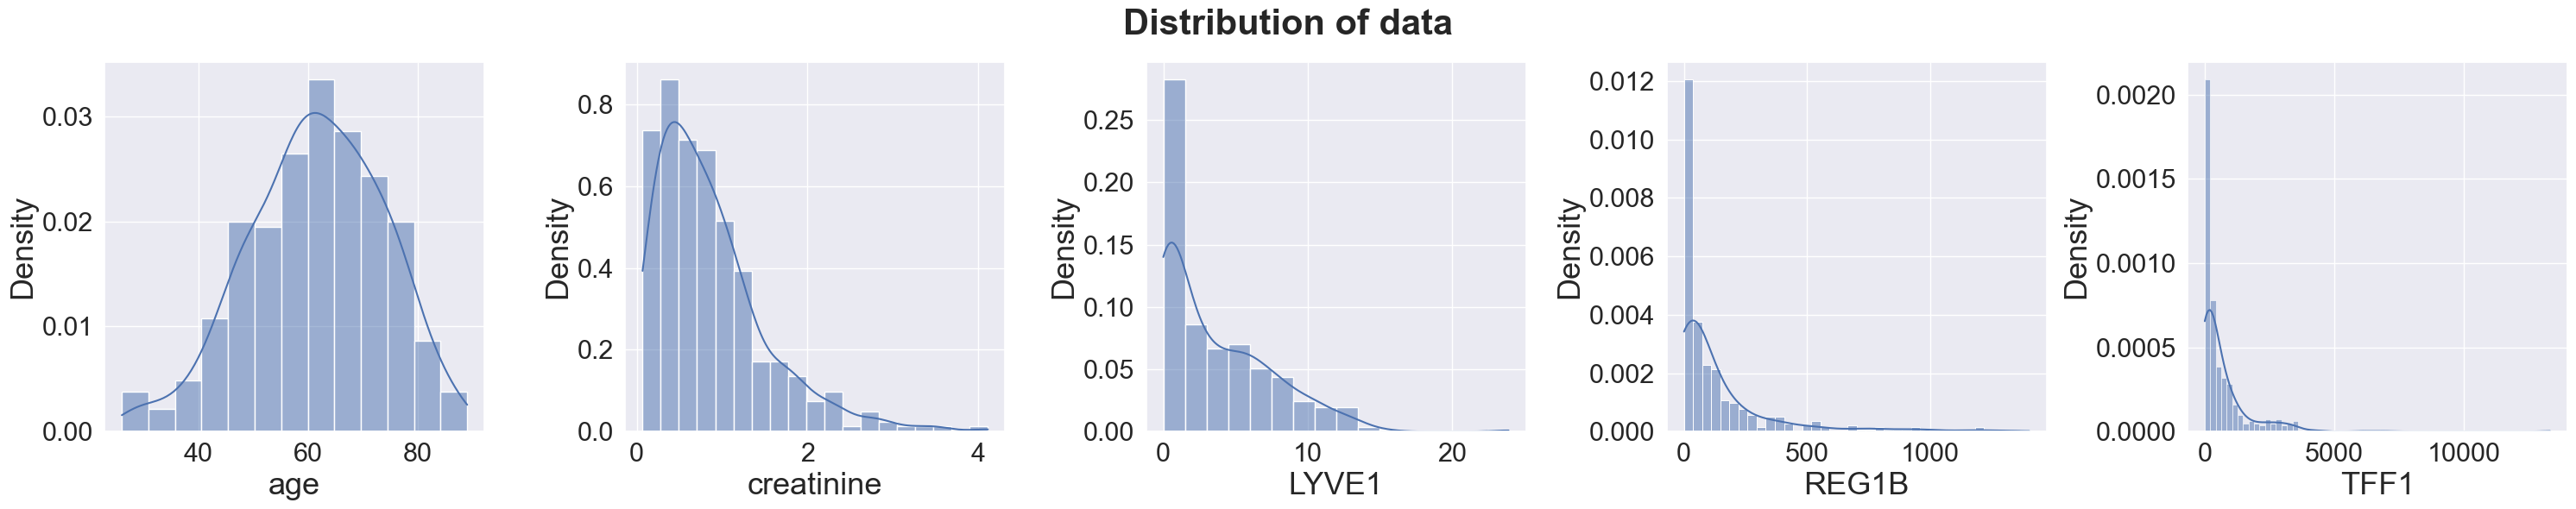

In [49]:
def data_dist(X, predictors, title):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 6)) # Create the figure and axis
    fig.suptitle(title, fontsize=30, fontweight='bold')         # Set main figure title                   
    
    sns.set()                                      # Reset plot style 
    axes = axes.ravel()                            # Flatten the array for easier idexing
    for pred, ax in zip(predictors, axes):         # Loop through each predictor
        sns.histplot(data=X[pred],                 # Plot histograms with density            
                     kde=True, 
                     stat='density',
                     ax=ax) 
        ax.xaxis.get_label().set_fontsize(26)      # Set fontsize for X-axis label  
        ax.yaxis.get_label().set_fontsize(26)      # Set fontsize for Y-axis label
        ax.tick_params(labelsize=22)               # Set fontsize for tick labels
       
    fig.tight_layout()                             # Adjust subplot params to fits in figure area
    plt.show()                                     # Show plots
    #plt.savefig('dist_plot.png', format='png', dpi=330)

data_dist(X, predictors, title='Distribution of data')

The subplots show that ’age’ resembles a normal distribution which is slightly asymmetrical with a small negative skew, whereas ’creatinine’ and the three biomarkers (’LYVE1’, ’REG1B’, and ’TFF1’) tend to have a long ’tail’ on one side of the graph, i.e., they follow a positively skewed distribution.

#### 2.5. Explore range of values

Another essential aspect of features is the range of values, since ML algorithms are sensitive to the scale of the input data; when features have different scales, the ML model might confuse a feature with a larger magnitude as the one with higher impact. For instance, if one feature is measured in units of thousands while another is measured in fractions, the algorithm may assign more weight to the feature with the larger scale, even if the smaller scale feature is more important. For this purpose, I have used boxplots to visualize the data range for each feature as displayed here:

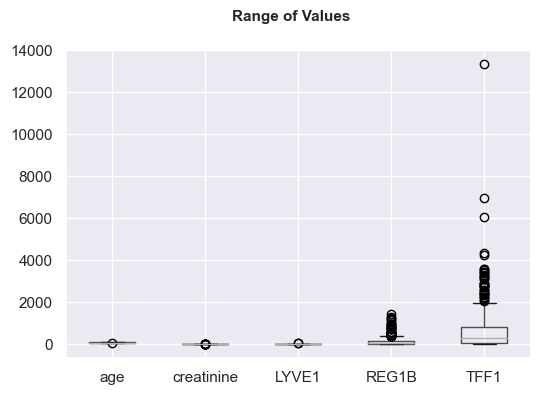

In [50]:
# Healthy control vs. PDAC data set
X.boxplot(figsize=(6, 4), fontsize=11) 
plt.suptitle('Range of Values', fontsize=11, fontweight='bold')
plt.show()

It is clear from the plot above that the features have very different scales and contain outliers: REG1B and TFF1 have a larger scale of values and they squish other boxplots into a line. 

For a further comparison, I present here also a summary of X which confirms that the data contains feature sets (or columns) that differ greatly in range and magnitude from each other:

In [51]:
# Print summary of the data 
X.describe().round(2)

,age,creatinine,LYVE1,REG1B,TFF1
count,382.00,382.00,382.00,382.00,382.00
mean,61.46,0.86,3.60,137.69,679.33
std,12.36,0.65,3.80,224.32,1154.66
min,26.00,0.07,0.00,0.00,0.01
25%,53.00,0.36,0.19,13.44,39.22
50%,62.00,0.71,2.23,47.48,277.21
75%,70.75,1.14,5.91,149.95,817.19
max,89.00,4.12,23.89,1403.90,13344.30


To solve the issue of one feature having a much larger variance than others and to ensure that all features are on a similar scale following more or less a normal distribution, I have performed scaling and transformation of the data in a preprocessing step. For ’age’, which assumed Gaussian-like distribution, I used the StandardScaler to remove the mean and scale the data such that the distribution is centered around 0, with a standard deviation of 1. Focusing next on the other features (’creatinine’, ’LYVE1’, ’REG1B’, and ’TFF1’) and taking into account their heavily skewed distribution as well as the presence of outliers, it would be unwise to use the mean and the standard deviation to scale them. Instead, I applied PowerTransformer which uses a power function (like a logarithm or exponent) to map any distribution which is afflicted with a skew or outliers to a Gaussian one or more-Gaussian like.

A very common problem which is related to data preparation techniques is data leakage which, although usually small, can have a marked effect on the model’s performance. Data leakage refers to a problem where information about the test or validation data set, is made available to the model in the training. One can avoid data leakage by dividing the data into training and testing
sets before preprocessing, fit the scalers/transformers to the training data, and then use only the transform method to scale the testing data. Alternatively, one can use the scalers/transformers in a pipeline and let scikit-learn take care of data leakage (under the hood) when fitting and transforming features.

### 3. Split the data

The train_test_split function is used to split the data, such that 20% of the data will be used for testing as indicated by the test size parameter set to 0.2, and the remaining 80% will be used for training. The random state parameter is set to 42 to ensure that the results are reproducible. The stratify parameter is set to y, which means that the splitting is done in a way that preserves the distribution of classes.

Next, the LabelEncoder is used to encode the categorical data in the target variable y to integer labels. The fit transform method is used to fit the encoder to y train and transform it into integer labels, whereas the transform method is used to transform y test into integer labels using the same encoder.

In [52]:
# Split data into training and testing sets in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
   
# Encode categorical data to integer labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)     # Fit and transform training labels 
y_test = le.transform(y_test)           # Transform testing labels
 
# Check mapping of categorical data and print results
le_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_map)

{'Healthy control': 0, 'PDAC': 1}


After splitting the data, I relied on scikit-learn to take care of the data leakage by including the preprocessing step in a pipeline. This, solely for the reason that I use cross-validation to evaluate the performance of the ML models, which requires data preprocessing method to be prepared on the training set and applied to the train and test sets within the cross-validation procedure. 

Since the pipeline is created latter in the code, for now, it suffices to show the effect of StandardScaler and PowerTransformer on the training  data after the preprocessing step has taken place.

**Distribution of data:** the skewness is minimized and the features resemble more Gaussian-like distrubution.

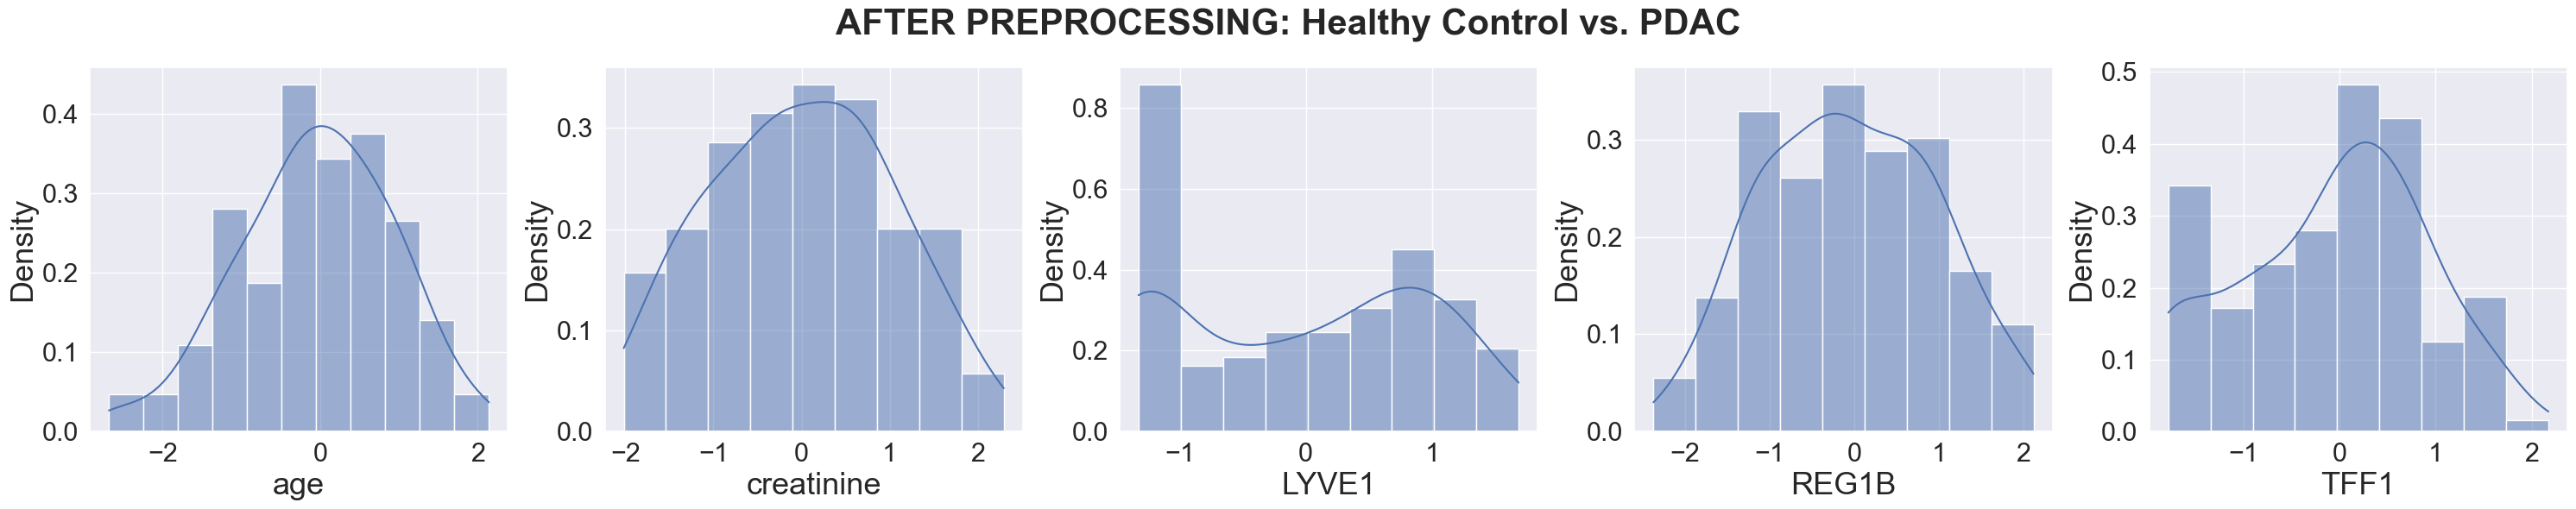

In [53]:
# List of protein features 
proteins = ['creatinine', 'LYVE1', 'REG1B', 'TFF1']

# Preprocessing algorithms
pt = PowerTransformer()
ss = StandardScaler()

# Transform colums with protein features
X_train[proteins] = pd.DataFrame(
    pt.fit_transform(X_train[proteins]), 
    columns=[proteins]
)

# Scale 'age' column
X_train[["age"]] = pd.DataFrame(
    ss.fit_transform(X_train[["age"]]), 
    columns=["age"]
)

# Plot data distribution 
data_dist(X_train, predictors, title='AFTER PREPROCESSING: Healthy Control vs. PDAC')
plt.show()

**Range of values:** all features in the training set have more or less the same scale.

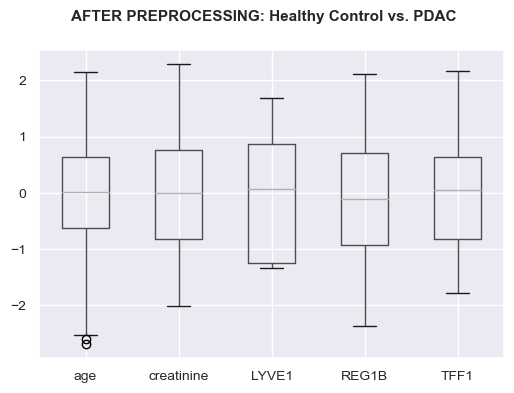

In [54]:
# Explore range of values using box plots
X_train.boxplot(figsize=(6, 4), fontsize=10) 
plt.suptitle('AFTER PREPROCESSING: Healthy Control vs. PDAC', fontsize=11, fontweight='bold')
plt.show()

**Mean and variance:** features are standardized (centered around 0 and unit variance).

In [55]:
# Mean 
X_train.mean().round(2) 

age          -0.04
creatinine    0.00
LYVE1        -0.04
REG1B        -0.05
TFF1         -0.07
dtype: float64

In [56]:
# Variance
X_train.var().round(2)

age           0.95
creatinine    1.06
LYVE1         1.00
REG1B         1.03
TFF1          0.96
dtype: float64

### 4. Creating the ML model pipeline with hyperparameter tuning

Evaluation of the ML models with hyperparameter tuning compromises the main section of the whole code. It consists of several parts summarized in the following bullet points/sections:

* First, the protein predictors have been grouped in a list, to be used in the subsequent step for a separation of these features from the ’age’ column. Then, a ColumnTransformer has been defined with the StandardScaler to be applied to the ’age’ column and the PowerTransformer to be applied to the protein columns: ’creatinine’, ’LYVE1’, ’REG1B’, and ’TFF1’.


In [57]:
# List of protein features 
proteins = ['creatinine', 'LYVE1', 'REG1B', 'TFF1']
# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['age']),
        ('log_transform', PowerTransformer(), proteins)
    ]
)

* Three classifiers have been chosen for investigation: Random Forest, Support Vector Classification (SVC), and K-Nearest Neighbors (KNN). For each classifier: a name, an abbreviation, the classifier object itself, and a dictionary of hyperparameters to tune are specified and grouped as elements of the newly defined classifiers list. Each key-value pair in the dictionary represents a hyperparameter to be tuned, where the key is the name of the hyperparameter and the value is a list of possible values for that hyperparameter. Where appropriate, the random state has been set to control the pseudo random number generation for shuffling the data and to produce reproducible output across multiple function calls. For SVC, probability estimates has been enabled (probability=True), since SVC does not provide this directly. Such an action is needed to be able to calculate the AUC scores as well as to make predictions later on when using the ’soft’ voting (in the VotingClassifier) that relies on the weighted average of predicted probabilities for the final class. Noteworthy, the probabilities in SVC are calculated using an expensive five-fold cross-validation and for this reason (to reduce computational costs), the ’accuracy’ has been set as a tracking metric for the grid search, instead of ’roc auc’ (see next bullet points).

In [58]:
# Define classifiers and hyperparameters to tune
classifiers = [
    {
        'name': 'Random Forest',
        'abbr': 'RF',
        'clf': RandomForestClassifier(random_state=42),    # Random state for reproducibility
        'hyperparameters': {
            'clf__max_features': ['sqrt', 'log2', None],   # No. features at at each split
            'clf__n_estimators': [10, 50, 100],            # No. trees in the forest
            'clf__criterion': ['gini', 'entropy'],         # Func. to measure the quality of a split
            'clf__max_depth': [5, 10, 20, None],           # Max. depth of the tree 
            'clf__min_samples_split': range(2, 10, 1),     # Min. no. samples for each split
            'clf__min_samples_leaf': range(1, 10, 1)       # Min. no. samples for each leaf node
        }
    },
    {
        'name': 'Support Vector Classification',
        'abbr': 'SVC',                                        # Random state for reproducibility
        'clf': SVC(random_state=42, probability=True),        # Probability estimates for AUC score                
        'hyperparameters': {
            'clf__C': [0.001, 0.1, 1, 10, 100],               # Regularization parameter
            'clf__kernel': ['linear','poly','rbf','sigmoid'], # Kernel type: how input variables are projected 
            'clf__gamma': ['scale', 'auto']                   # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
        }
    },
    {
        'name': 'K-Nearest Neighbors',
        'abbr': 'KNN',
        'clf': KNeighborsClassifier(),
        'hyperparameters': {
            'clf__n_neighbors': range(1, 21, 2),                   # No. neighbors
            'clf__metric': ['euclidean','manhattan','minkowski'],  # Metric for distance computation
            'clf__weights': ['uniform', 'distance']                # Contribution of members of the neighborhood 
        }
    }
]

* Cross-validation, more specifically, the RepeatedStratifiedKFold cross-validator configured to three repeats (n repeats=3 ) and ten folds (n splits=10 ) has been used to evaluate the performance of the specified classifiers and the respective combination of hyperparameters. This procedure is in compliance with the recommended practice for classification tasks. Repeated means that the whole cross-validation procedure is repeated multiple times (3 in this case), whereas stratified means the percentage of samples for each class is preserved at each fold. To store the results of the cross-validation with hyperparameter tuning, two empty lists results and best classifiers have been defined.

In [59]:
# Define evaluation method
rskf = RepeatedStratifiedKFold(n_splits=10,       # 10 folds
                               n_repeats=3,       # 3 repeats
                               random_state=1)    # Random state for reproducibility

# Define empty lists to store results
results = []
best_classifiers = []

* Next, the code loops through each classifier c from the classifiers list. Inside this loop, a Pipeline is constructed assembling two sequential steps to be cross-validated together:

    - **preprocessing:** applies the column transformer to the input features, i.e., performs scaling and standardization of the data, and

    - **clf:** refers to the classification algorithm from the list of classifiers.
    
  

In [60]:
# Loop through classifiers
for c in classifiers:
    # Define pipeline with preprocessor and classifier
    pipeline = Pipeline([
        ('preprocessing', column_transformer),
        ('clf', c['clf'])
    ])

**NOTE:** All of the subsequent bullet points are performed within this for-loop. The full code starting from the for-loop and which can be executed will be given afterwards.

* Tuning of the hyperparameters is performed using the GridSearchCV technique. The GridSearchCV object is linked to the workflow of operations defined in the previously specified pipeline, which includes the preprocessing step and the final classifier. The best performing hyperparameters for each classifier are chosen by exhaustively searching over all possible combinations of hyperparameters specified in a dictionary (c['hyperparameters']), The third argument is scoring=’accuracy’ which specifies the metric to track during the hyperparameter search using RepeatedStratifiedKfold cross-validation (cv=rskf). In this case, the metric being used measures the proportion of correctly classified instances for each combination. To speed up the search process the n jobs has been set to -1 to use all available cores on the computer for parallelization. Last, refit=True dictates that after the grid search is complete, the final model should refit on the entire training data. The GridSearchCV object is then fit to the training data (X_train and y_train).

In [ ]:
# Define grid search with cross-validation to tune hyperparameters
grid_search = GridSearchCV(pipeline,             # ML workflow
                           c['hyperparameters'], # Hyperparameter dictionary
                           scoring = 'accuracy', # Metric to track
                           n_jobs=-1,            # Parallelization using all cores
                           cv=rskf,              # Evaluate with RSKF cross-validation
                           refit=True)           # Refit classifier with best hyperparam. 
                                                 ## on whole training data 
# Fit grid search to training data
grid_search.fit(X_train, y_train)

* Once the cross-validation procedure with hyperparameter tuning is finished, the best performing model found by the grid search is accessed using the best estimator attribute of the GridSearchCV and saved to the variable best model. The best model is appended to the list of best classifiers as a tuple containing the abbreviation of the classifier (c[’abbr’] ) and the classifier object itself (best model[1] ). The list of best classifiers is needed for the final part of this project, to build and evaluate an ensemble of the best performing estimators. Next, the best model has been used to make prediction on the testing set, and its performance has been determined in terms of the accuracy score. To comply with published results by Debernardi et al., the best models have been additionally used to predict probability estimates for y train and y test and to calculate the respective AUC training and testing scores. All results, rounded up to 3 decimal places and represented as a dictionary, are appended to the list of results. They include: the name of the classifier, the best performing hyperparameters, the training and testing accuracy, and AUC scores.

In [ ]:
    # Select model with best performing hyperparameters
    # Append model with best hyperparameters to best_classifiers
    best_model = grid_search.best_estimator_
    best_classifiers.append((c['abbr'], best_model[1])) # best_model[0] is the preprocessing step
         
    # Evaluate best model on test data
    test_acc = accuracy_score(y_test, best_model.predict(X_test)) 
    
    # Calculate AUC scores
    # Predict probability estimates for y_train and calculate AUC train score
    # Predict probability estimates for y_test and calculate AUC test score
    train_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:,1])
    test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
     
    # Append results to list
    results.append({
        'Classifier': c['name'], 
        'Best Parameters': grid_search.best_params_,
        'Training accuracy': round(grid_search.best_score_, 3), 
        'Testing accuracy': round(test_acc, 3),  
        'AUC train score': round(train_auc, 3),
        'AUC test core': round(test_auc, 3)
        })


**The full code starting from the for-loop and which can be executed is shown here:**

In [ ]:
# Loop through classifiers
for c in classifiers:
    # Define pipeline with preprocessor and classifier
    pipeline = Pipeline([
        ('preprocessing', column_transformer),
        ('clf', c['clf'])
    ])
    
    # Define grid search with cross-validation to tune hyperparameters
    grid_search = GridSearchCV(pipeline,             # ML workflow
                               c['hyperparameters'], # Hyperparameter dictionary
                               scoring = 'accuracy', # Metric to track
                               n_jobs=-1,            # Parallelization using all cores
                               cv=rskf,              # Evaluate with RSKF cross-validation
                               refit=True)           # Refit classifier with best hyperparam. 
                                                     ## on whole training data 
    # Fit grid search to training data
    grid_search.fit(X_train, y_train)

    # Select model with best performing hyperparameters
    # Append model with best hyperparameters to best_classifiers
    best_model = grid_search.best_estimator_
    best_classifiers.append((c['abbr'], best_model[1])) # best_model[0] is the preprocessing step
         
    # Evaluate best model on test data
    test_acc = accuracy_score(y_test, best_model.predict(X_test)) 
    
    # Calculate AUC scores
    # Predict probability estimates for y_train and calculate AUC train score
    # Predict probability estimates for y_test and calculate AUC test score
    train_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:,1])
    test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
     
    # Append results to list
    results.append({
        'Classifier': c['name'], 
        'Best Parameters': grid_search.best_params_,
        'Training accuracy': round(grid_search.best_score_, 3), 
        'Testing accuracy': round(test_acc, 3),  
        'AUC train score': round(train_auc, 3),
        'AUC test core': round(test_auc, 3)
        })
    
# Print results
for r in results:
    print(f"{r['Classifier']} \n \
        Training accuracy: {r['Training accuracy']} \n \
        Testing accuracy: {r['Testing accuracy']} \n \
        AUC train score: {r['AUC train score']} \n \
        AUC test score: {r['AUC test core']}")    
      
# RESULTS
# Random Forest 
#          Training accuracy: 0.87 
#          Testing accuracy: 0.883 
#          AUC train score: 0.992 
#          AUC test score: 0.962
# Support Vector Classification 
#          Training accuracy: 0.863 
#          Testing accuracy: 0.922 
#          AUC train score: 0.956 
#          AUC test score: 0.957
# K-Nearest Neighbors 
#          Training accuracy: 0.867 
#          Testing accuracy: 0.87 
#          AUC train score: 0.947 
#          AUC test score: 0.971

### 5. Building and evaluating an ensemble model

Finally, an ensemble is constructed using the VotingClassifier. The voting has been set to ’soft’ as this is recommended for an ensemble of well-calibrated classifiers. Next, the ensemble pipeline containing the preprocessing step and the VotingClassifier with the estimators set to the best classifiers has been fit to the training data using the fit method. Predictions have been made for the training and testing data, and the ensemble has been evaluated in terms of both, the accuracy_score and roc_auc score. All results, have been printed in the console.

In [ ]:
# Define classifiers with best performing hyperparameters
# best_classifiers = [
#     ('RF', RandomForestClassifier(
#         criterion='entropy', 
#         max_depth=5,
#         max_features='sqrt',
#         min_samples_leaf=1,
#         min_samples_split=5,
#         n_estimators=50, 
#         random_state=42)),
#     ('SVC', SVC(
#         C=1,
#         gamma='scale',
#         kernel='rbf',
#         random_state=42,                
#         probability=True)),              
#     ('KNN', KNeighborsClassifier(
#         metric='manhattan', 
#         n_neighbors=17,
#         weights='uniform'))
# ]

# Define pipeline with preprocessor and voting classifier
en_pipe = Pipeline([
    ('preprocessing', column_transformer),
    ('ensemble', VotingClassifier(estimators=best_classifiers, voting='soft'))
])

# Preprocess and fit model to training data
# Calculate accuracy score
# Predict probability estimates for y_train and calculate AUC train score
en_pipe.fit(X_train, y_train)
en_train_acc = accuracy_score(y_train, en_pipe.predict(X_train))
en_train_auc = roc_auc_score(y_train, en_pipe.predict_proba(X_train)[:,1])

# Evaluate the ensemble model on test data 
# Calculate accuracy score
# Predict probability estimates for y_test and calculate AUC test score
en_test_acc = accuracy_score(y_test, en_pipe.predict(X_test))
en_test_auc = roc_auc_score(y_test, en_pipe.predict_proba(X_test) [:,1])

# Print results
print('Ensemble training accuracy', round(en_train_acc, 3))
print('Ensemble testing accuracy:', round(en_test_acc, 3))
print('Ensemble AUC train score:', round(en_train_auc, 3))
print('Ensemble AUC test score:', round(en_test_auc, 3))

# RESULTS
# >>> Ensemble training accuracy 0.918
# >>> Ensemble testing accuracy: 0.883
# >>> Ensemble AUC train score: 0.975
# >>> Ensemble AUC test score: 0.975